In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scikitplot as skplt

# settings
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# import models from sklearn
from sklearn import datasets, metrics, naive_bayes
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from matplotlib.colors import ListedColormap
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import scipy.stats as stats

# skip warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# change cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [71]:
class full_classification:
    """A class which automatically does all classification models and gridsearches for you (logisitic default). 
    Note: when you run a new model it will overwrite the previous model. You can access the current model with .model and .model_des.
    Other options:
    run_all = default True, if set to false the class will not automatically run any models
    baseline = default 0, set this to your baseline accuracy measure for comparision stats
    standardize = default True, uses standard scaler and fit-transforms on train, transform on test if exists
    test_size = default 0.15, decide the side of your test set - set to 0 if dont want test
    folds = default 6, amount of folds for cross validation - integer > 1
    shuffle = default True, shuffle the data for test split and cross val
    stratify = default None, input the variable that you which to stratify the data by
    print_info = default True, print all of the results out every time you run a model
    save_it = default False, this adds functionality to be able to save down all model results into a
              dataframe, set as a global variable called model_tracker.
    comment = default None, This is a comment field for the model_tracker
    Go to readme for further information: https://github.com/LukeBetham/machine-learning-classes/blob/master/README.md
    Created by LukeBetham"""

    def __init__(self, X, y, run_all=True, baseline=0, standardize=True,
                 test_size=0.15, folds=6, shuffle=True, stratify=None,
                 print_info=True, save_it=False, comment=None):
        # Save settings to object
        self.folds = folds
        self.shuffle = shuffle
        self.stratify= stratify
        self.comment = comment
        self.save_it = save_it
        self.print_info = print_info
        if self.stratify == None:
            self.kfold = KFold(self.folds, shuffle=self.shuffle, random_state=66)
        else:
            self.kfold = StratifiedKFold(self.folds, shuffle=self.shuffle, random_state=66)
        # Option for bolding print text
        self.BOLD = '\033[1m'
        self.END = '\033[0m'
        # Create train-test split if selected
        self.X = X
        self.y = y
        self.baseline = baseline
        self.test = test_size
        if self.test != 0:
            self.X, self.X_test, self.y, self.y_test, self.index_train, self.index_test = train_test_split(
                self.X, self.y, self.X.index, test_size=self.test, shuffle=self.shuffle, stratify=self.stratify, 
                random_state=66)
        # Standardise the data if selected
        if standardize != 'none':
            scaler = StandardScaler()
            self.X = pd.DataFrame(
                scaler.fit_transform(self.X), columns=self.X.columns)
            if self.test != 0:
                self.X_test = pd.DataFrame(
                    scaler.transform(self.X_test), columns=self.X.columns)
        # Run all models
        if run_all==True:
            self.knn_model()
            self.decision_tree_model()
            self.logistic_model()
            self.random_forest_model()
            self.ADAboosting_model()
            self.GradientBoosting()
            self.NaiveBayes()
            self.LinearSVC()
            #only enable this one if small dataset or want to wait a while
            self.PolynomialSVC()
            self.GaussianSVC()

    def logistic_model(self, Logistic=LogisticRegression()):
        # Set up Logistic Regresssion
        self.model = Logistic
        self.model_des = "Logistic Regression Model"
        self.grid_multiple = 30
        self.model_calc()
        if self.print_info==True:
            print("Run .coefs() to see coef dataframe")

    def knn_model(self, KNN=KNeighborsClassifier(n_neighbors=10)):
        # set up KNN model
        self.model = KNN
        self.model_des = "K Neighbors Model"
        self.grid_multiple = 30
        self.model_calc()
        if self.print_info==True:
            print("Run .knn_all_k() to run all possible k values and find best k value.")

    def knn_all_k(self, limit = 400):
        # run KNN for all possible Ks and graph them
        self.scores = []
        self.max_k = np.minimum(limit,int(len(self.y)*(1-(1/self.folds))-1))
        for k in range(1, self.max_k):
            knn = KNeighborsClassifier(n_neighbors=k)
            self.scores.append(np.mean(cross_val_score(knn, self.X, self.y, cv=self.kfold)))
        self.knn_best = self.scores.index(np.max(self.scores))+1
        plt.plot(range(1, self.max_k), self.scores, label='Mean CV Scores')
        plt.hlines(self.baseline, 1, self.max_k, label='baseline')
        plt.xlabel('k')
        plt.ylabel('accuracy')
        plt.legend(loc=[1.1, 0])
        print(self.BOLD + "Highest KNN Score:" + self.END, self.knn_best)
        plt.show()

    def decision_tree_model(self, print_tree=False, DecisionTree=DecisionTreeClassifier(criterion='gini', splitter='best',
                                                                                        max_depth=None, random_state=66)):
        # set up decision tree model
        self.model = DecisionTree
        self.model_des = "Decision Tree Model"
        self.grid_multiple = 50
        self.model_calc()
        if print_tree == True:
            dot_data = StringIO() 
            export_graphviz(self.model, out_file=dot_data, filled=True, rounded=True,
                            special_characters=True, feature_names=self.X.columns)  

            graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
            display(Image(graph.create_png()))

    def random_forest_model(self, forest=RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, random_state=66)):
        self.model = forest
        self.model_des = "Random Forest Model"
        self.grid_multiple = 9.5
        self.model_calc()

    def ADAboosting_model(self, plot_it=False, estimators=100, base_estimator=DecisionTreeClassifier(max_depth=3,random_state=66)):
        self.model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=estimators,
                                        algorithm='SAMME', random_state=66)
        self.model_des = "ADA Boosting Model"
        self.grid_multiple = 2.5
        self.model_calc()
        # plot
        if plot_it == True:
            plt.plot(list(self.model.staged_score(self.X, self.y)),
                     label='training score', lw=2)
            plt.plot(list(self.model.staged_score(
                self.X_test, self.y_test)), label='test score', lw=2)
            plt.xlabel('iteration')
            plt.ylabel('score')
            plt.legend()
            plt.show()
            
    def GradientBoosting(self, grad_model=GradientBoostingClassifier(n_estimators=100)):
        self.model = grad_model
        self.model_des = "Gradient Boosting Model"
        self.grid_multiple = 2.5
        self.model_calc()
    
    def NaiveBayes(self, nbtype = naive_bayes.GaussianNB(),power_transform=False):
        self.model = nbtype
        self.model_des = "Naive Bayes Model"
        self.grid_multiple = 2.5
        # With the option to power transform to make distribution more normal for the GaussianNB          
        if power_transform == True:
            X_temp, X_test_temp = self.X.copy(), self.X_test.copy()
            power = PowerTransformer()
            self.X = pd.DataFrame(power.fit_transform(self.X),columns=self.X_tp.columns)
            self.X_test = power.transform(self.X_test)
            self.model_des = self.model_des +" with Power Transform"
            self.model_calc()
            self.X, self.X_test = X_temp.copy(), X_test_temp.copy()
        else:
            self.model_calc()
    
    def LinearSVC(self,svc = LinearSVC(C=1, loss="hinge")):
        self.model = svc
        self.model_des = "Linear Support Vectors Model"
        self.grid_multiple = 0.5                  
        self.model_calc()
        
    def PolynomialSVC(self,psvc = SVC(kernel="poly", degree=3, coef0=1, C=5)):
        self.model = psvc
        self.model_des = "Polynomial Support Vectors Model"
        self.grid_multiple = 4.5 
        self.model_calc()
        
    def GaussianSVC(self,gsvc = SVC(kernel="rbf", gamma=5, C=0.001)):
        self.model = gsvc
        self.model_des = "Gaussian (rbf) Support Vectors Model"
        self.grid_multiple = 15
        self.model_calc()
    
    def MLP_Neural_Net(self,params = MLPClassifier(solver='adam', alpha=10**(0),
                                        hidden_layer_sizes=(10, 10, 10), activation='relu',
                                        random_state=42, batch_size=50,max_iter=500)):
        self.model = params
        self.model_des = 'MLP Classifier Neural Net'
        self.grid_multiple = 15
        self.model_calc()

    def coefs(self):
        self.dfc = pd.DataFrame(self.coef, columns=self.X.columns)
        return self.dfc

    def model_calc(self):
        # fit model
        t0 = time.time()
        self.model.fit(self.X, self.y)
        self.sc = self.model.score(self.X, self.y)
        self.cvs = cross_val_score(self.model, self.X, self.y, cv=self.kfold).mean()
        # Get test score
        if self.test != 0:
            self.sct = self.model.score(self.X_test, self.y_test)
            self.sctp = str(round(self.sct, 4))+" - better than baseline by " + \
                str(round(self.sct-self.baseline, 4))
        else:
            self.sctp = None
        # time the running of the model
        t1 = time.time()
        self.elaspsed = t1-t0
        # show the results from the classification model
        if self.print_info==True:
            print('\n',self.BOLD + self.model_des, 'Test\nModel Score:' + self.END, round(self.sc, 4), "- better than baseline by", round(self.sc-self.baseline, 4),
                  self.BOLD + '\nCV Fold Score:' +
                  self.END, round(
                      self.cvs, 4), "- better than baseline by", round(self.cvs-self.baseline, 4),
                  self.BOLD + "\nModel Test Score:" + self.END, self.sctp)
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*self.grid_multiple, 2), 'minutes to run.')
        try:
            self.coef = self.model.coef_
            self.coefs
        except:
            pass
        if self.save_it == True:
            self.tracking()
            print("Saved model to global model tracker.")
            
    def tracking(self):
        global model_tracker
        if not isinstance(model_tracker, pd.DataFrame):
            model_tracker = pd.DataFrame(columns = ['model_type','model_train_score','cv_score',
                                                    'test_score','predictors','baseline',
                                                    'cv_above_baseline','model_params','time',
                                                    'comment'])
        df_temp = pd.DataFrame({'model_type':self.model_des,'model_train_score':self.sc,
                                'cv_score':self.cvs,'test_score':self.sct,'predictors': str(','.join(self.X.columns)),
                                'baseline':self.baseline,'cv_above_baseline':self.cvs-self.baseline,
                                'model_params':str(self.model),'time':self.elaspsed,'comment':self.comment},
                               index=[len(model_tracker.index)])
        model_tracker =  pd.concat([model_tracker,df_temp])

    def gridsearch(self, params='default', cores = 1):
        """A function which automatically runs a gridsearch on your selected model. Returns model_grid model with best parameters.
        Defaults for Logistic (600 iterations): {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': np.logspace(-5, 5, 5), 'l1_ratio': np.linspace(0.0001, 1, 4)}
        Defaults for KNN: self.params (100 iterations) = {'n_neighbors':range(1,20,1), 'weights':['uniform','distance'], 'p':[1,2]}         
        Defaults for Decision Tree (1000 iterations) = {'criterion':['gini','entropy'],'max_depth': [None,5,6,7,8],'max_features':['auto'],'splitter':['best','random'],'min_samples_split':[2,3,4,5],'ccp_alpha':[0.0,0.0001,0.001,.01,.1,1,10,100],'class_weight':[None,'balanced']}        
        Defaults for Random Forest (575 iterations) = {'n_estimators':[100,200,500], 'criterion':['gini':'entropy'], 'max_depth':[None], 'min_samples_split':[2,4,6],"max_features":["auto","log2"],'oob_score':[True,False],'warm_start':[True,False],'ccp_alpha'=[0.0,0.5,1,10]}      
        Defaults for ADABoosting Model  (150 iterations)  = {"learning_rate": [0.05, 0.25, 0.5, 0.75, 1], "max_depth":[1,2,3,4,5],"max_features":["auto","log2"],"n_estimators":[100,200,500]}      
                """
        # setting the default parameters if not set by user
        if params == 'default':
            if self.model_des == "Logistic Regression Model":
                self.params = {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': np.logspace(-5, 5, 5), 'l1_ratio': np.linspace(0.0001, 1, 4)}
            elif self.model_des == "K Neighbors Model":
                self.params = {'n_neighbors': range(1, 20, 1), 'weights': ['uniform', 'distance'], 'p': [1, 2]}
            elif self.model_des == "Decision Tree Model":
                self.params = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 6, 7, 8], 'max_features': ['auto'], 'splitter': [
                    'best', 'random'], 'min_samples_split': [2, 3, 4, 5], 'ccp_alpha': [0.0, 0.0001, 0.001, .01, .1, 1, 10, 100], 'class_weight': [None, 'balanced']}
            elif self.model_des == "Random Forest Model":
                self.params = {'n_estimators':[100,200,500], 'criterion':['gini','entropy'], 'max_depth':[None], 'min_samples_split':[2,6],"max_features":["auto","log2"],
                               'oob_score':[True,False],'warm_start':[True,False],'ccp_alpha':[0.0,0.5,1]}
            elif self.model_des == "ADA Boosting Model": 
                self.params = {"learning_rate": [0.05, 0.25, 0.5, 0.75, 1], 'base_estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)],
                               'algorithm':['SAMME'],"n_estimators":[100,200,500,1000]}
            elif self.model_des == "Gradient Boosting Model":  
                pass
            elif self.model_des == "Naive Bayes Model":
                pass
            elif self.model_des == "Linear Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,20),'loss':['hinge','squared_hinge']}
            elif self.model_des == "Gaussian (rbf) Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,15),'gamma':np.linspace(0.00001,100,15),'kernel':['rbf']}
            elif self.model_des == "Polynomial Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,15),'coef0':[0,1,2,3,4,10],'kernel':['poly'],'degree':[2,3,4]}
        else:
            self.params = params
        # setup the gridsearch
        self.grid = GridSearchCV(self.model, self.params, verbose=1, n_jobs=cores, cv=StratifiedKFold(
            self.folds, shuffle=self.shuffle, random_state=66))
        self.grid.fit(self.X, self.y)
        self.gsc = self.grid.best_score_
        self.best = self.grid.best_params_
        self.model = self.grid.best_estimator_
        self.model_des = self.model_des + " Grid Search:"
        try:
            self.coef = self.grid.best_estimator_.coef_
        except:
            pass
        # Check test score for grid
        try:
            self.sct = self.grid.best_estimator_.score(
                self.X_test, self.y_test)
            self.sctp = str(round(self.sct, 4))+" - better than baseline by " + \
                str(round(self.sct-self.baseline, 4))
        except:
            self.sctp = None
        # Print Grid results
        if self.print_info==True:
            print(self.BOLD + self.model_des + self.END)
            print(self.BOLD + "Best Mean CV Model Score:" + self.END, round(self.gsc, 4), "- which is better than baseline by",
                  round(self.gsc-self.baseline, 4), self.BOLD + "\nModel Test Score:" + self.END, self.sctp)
            print(self.BOLD + 'Grid Best Parameters:\n' + self.END, self.best)
            print(self.BOLD + '\nSearch Parameters:\n' + self.END, self.params)
        self.coefs()

    def matrix_n_graphs(self, normalize=True):
        print(self.BOLD + self.model_des, "on X_test" + self.END)
        self.y_pred = self.model.predict(self.X_test)
        skplt.metrics.plot_confusion_matrix(
            self.y_test, self.y_pred, figsize=(8, 8), labels=[0, 1], normalize=normalize)
        plt.xlim(-0.5, len(self.model.classes_)-0.5)
        plt.ylim(len(self.model.classes_)-0.5, -0.5)
        plt.show()
        cmap = ListedColormap(sns.color_palette("husl", 3))
        skplt.metrics.plot_roc(self.y_test, self.model.predict_proba(self.X_test), plot_micro=False,
                               plot_macro=False, title_fontsize=20, text_fontsize=16, figsize=(8, 8), cmap=cmap)
        plt.show()
        fig, ax = plt.subplots(figsize=(8, 8))
        skplt.metrics.plot_precision_recall(self.y_test, self.model.predict_proba(
            self.X_test), plot_micro=False, title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
        ax.legend(loc=[1.1, 0])
        plt.show()


In [84]:
df = pd.read_csv('/Users/lukebetham/Documents/DSI_General_Assembly/resource-datasets/spam/spam_modified.csv')

In [85]:
df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_q,char_freq_r,char_freq_s,char_freq_t,char_freq_u,char_freq_v,char_freq_w,char_freq_x,char_freq_y,char_freq_z
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.151841,6.025115,5.561002,10.076847,2.965305,1.135276,2.899156,0.173810,2.128267,0.064742
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.085323,8.452674,5.477507,10.472582,2.594585,1.305323,2.924420,0.147157,2.215821,0.068813
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.105956,6.031863,6.545417,9.134362,3.231211,1.114674,2.834654,0.146050,1.622453,0.082799
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.103169,6.069449,6.318278,13.330856,3.446722,1.082342,2.900294,0.167818,2.201456,0.089043
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.150453,6.523384,4.379706,8.550212,2.852159,1.043007,2.919178,0.167830,2.224477,0.077263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.134810,6.969425,6.506657,9.083878,2.806490,1.112342,2.332016,0.181148,2.103606,0.073661
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.111216,7.582056,6.039642,12.205701,3.320295,1.061620,2.871755,0.169963,2.142562,0.069837
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.114570,6.273710,5.027087,6.340193,3.121744,1.373705,2.687749,0.152428,2.141778,0.070005
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.107181,6.327586,6.484284,9.233690,3.388902,1.119013,3.374184,0.183389,2.721075,0.078867


In [86]:
X = df

In [87]:
y = X.pop('is_spam')
y.value_counts(normalize=True)

0    0.605955
1    0.394045
Name: is_spam, dtype: float64

In [88]:
test_model = full_classification(X,y,baseline=0.606)


 K Neighbors Model Test
Model Score: 0.9274 - better than baseline by 0.3214 
CV Fold Score: 0.9051 - better than baseline by 0.2991 
Model Test Score: 0.932 - better than baseline by 0.326
Time Elapsed =  3.81 secs - grid will take ~ 114.26 minutes to run.
Run .knn_all_k() to run all possible k values and find best k value.

 Decision Tree Model Test
Model Score: 1.0 - better than baseline by 0.394 
CV Fold Score: 1.0 - better than baseline by 0.394 
Model Test Score: 1.0 - better than baseline by 0.394
Time Elapsed =  0.12 secs - grid will take ~ 5.76 minutes to run.

 Logistic Regression Model Test
Model Score: 0.9982 - better than baseline by 0.3922 
CV Fold Score: 0.9918 - better than baseline by 0.3858 
Model Test Score: 0.9957 - better than baseline by 0.3897
Time Elapsed =  0.17 secs - grid will take ~ 5.08 minutes to run.
Run .coefs() to see coef dataframe

 Random Forest Model Test
Model Score: 1.0 - better than baseline by 0.394 
CV Fold Score: 1.0 - better than baseline by

In [89]:
test_model.knn_model()


 K Neighbors Model Test
Model Score: 0.9274 - better than baseline by 0.3214 
CV Fold Score: 0.9051 - better than baseline by 0.2991 
Model Test Score: 0.932 - better than baseline by 0.326
Time Elapsed =  3.87 secs - grid will take ~ 116.2 minutes to run.
Run .knn_all_k() to run all possible k values and find best k value.


Highest KNN Score: 9


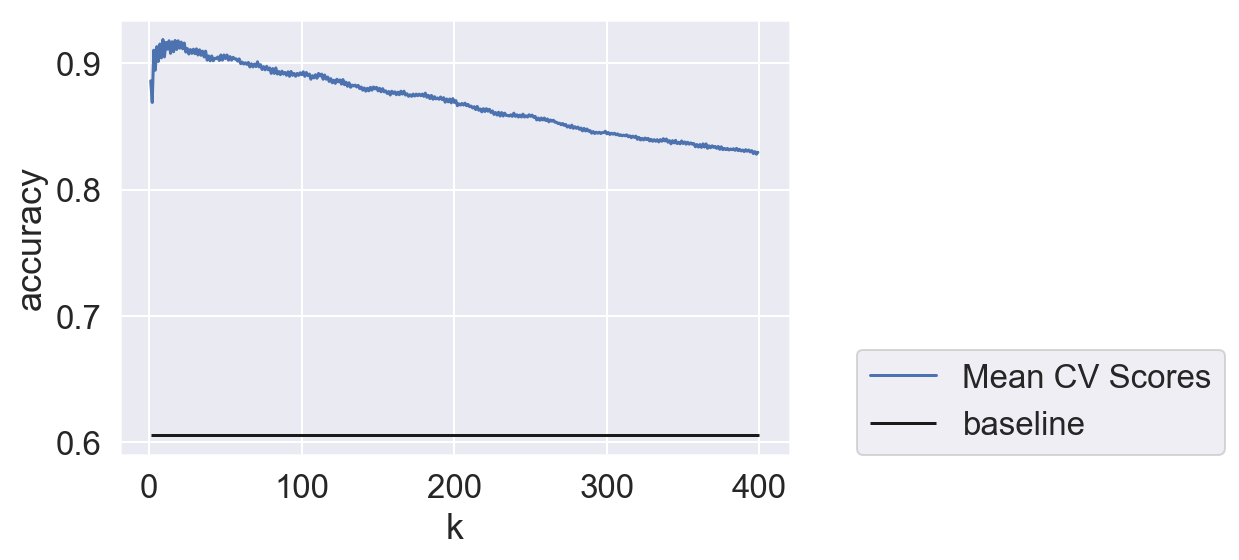

In [90]:
test_model.knn_all_k()

In [91]:
test_model.gridsearch()

Fitting 6 folds for each of 76 candidates, totalling 456 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 456 out of 456 | elapsed:  1.9min finished


K Neighbors Model Grid Search:
Best Mean CV Model Score: 0.9304 - which is better than baseline by 0.3244 
Model Test Score: 0.919 - better than baseline by 0.313
Grid Best Parameters:
 {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

Search Parameters:
 {'n_neighbors': range(1, 20), 'weights': ['uniform', 'distance'], 'p': [1, 2]}


In [92]:
test_model.decision_tree_model()


 Decision Tree Model Test
Model Score: 1.0 - better than baseline by 0.394 
CV Fold Score: 1.0 - better than baseline by 0.394 
Model Test Score: 1.0 - better than baseline by 0.394
Time Elapsed =  0.12 secs - grid will take ~ 5.91 minutes to run.


In [93]:
test_model.gridsearch()

Fitting 6 folds for each of 1280 candidates, totalling 7680 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Decision Tree Model Grid Search:
Best Mean CV Model Score: 0.9711 - which is better than baseline by 0.3651 
Model Test Score: 0.9566 - better than baseline by 0.3506
Grid Best Parameters:
 {'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 4, 'splitter': 'best'}

Search Parameters:
 {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 6, 7, 8], 'max_features': ['auto'], 'splitter': ['best', 'random'], 'min_samples_split': [2, 3, 4, 5], 'ccp_alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': [None, 'balanced']}


[Parallel(n_jobs=1)]: Done 7680 out of 7680 | elapsed:  1.1min finished


In [94]:
test_model.logistic_model()


 Logistic Regression Model Test
Model Score: 0.9982 - better than baseline by 0.3922 
CV Fold Score: 0.9918 - better than baseline by 0.3858 
Model Test Score: 0.9957 - better than baseline by 0.3897
Time Elapsed =  0.17 secs - grid will take ~ 5.22 minutes to run.
Run .coefs() to see coef dataframe


In [95]:
test_model.gridsearch()

Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.2min finished


Logistic Regression Model Grid Search:
Best Mean CV Model Score: 0.9903 - which is better than baseline by 0.3843 
Model Test Score: 0.9913 - better than baseline by 0.3853
Grid Best Parameters:
 {'C': 0.0031622776601683794, 'l1_ratio': 0.0001, 'penalty': 'l1', 'solver': 'saga'}

Search Parameters:
 {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': array([1.00000000e-05, 3.16227766e-03, 1.00000000e+00, 3.16227766e+02,
       1.00000000e+05]), 'l1_ratio': array([1.000e-04, 3.334e-01, 6.667e-01, 1.000e+00])}


In [96]:
test_model.random_forest_model()


 Random Forest Model Test
Model Score: 1.0 - better than baseline by 0.394 
CV Fold Score: 1.0 - better than baseline by 0.394 
Model Test Score: 1.0 - better than baseline by 0.394
Time Elapsed =  4.5 secs - grid will take ~ 42.78 minutes to run.


In [97]:
test_model.gridsearch()

Fitting 6 folds for each of 288 candidates, totalling 1728 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1728 out of 1728 | elapsed: 68.5min finished


Random Forest Model Grid Search:
Best Mean CV Model Score: 1.0 - which is better than baseline by 0.394 
Model Test Score: 1.0 - better than baseline by 0.394
Grid Best Parameters:
 {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True, 'warm_start': True}

Search Parameters:
 {'n_estimators': [100, 200, 500], 'criterion': ['gini', 'entropy'], 'max_depth': [None], 'min_samples_split': [2, 6], 'max_features': ['auto', 'log2'], 'oob_score': [True, False], 'warm_start': [True, False], 'ccp_alpha': [0.0, 0.5, 1]}


In [98]:
test_model.ADAboosting_model()


 ADA Boosting Model Test
Model Score: 1.0 - better than baseline by 0.394 
CV Fold Score: 1.0 - better than baseline by 0.394 
Model Test Score: 1.0 - better than baseline by 0.394
Time Elapsed =  0.16 secs - grid will take ~ 0.41 minutes to run.


In [99]:
test_model.gridsearch()

Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ADA Boosting Model Grid Search:
Best Mean CV Model Score: 1.0 - which is better than baseline by 0.394 
Model Test Score: 1.0 - better than baseline by 0.394
Grid Best Parameters:
 {'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'learning_rate': 0.05, 'n_estimators': 100}

Search Parameters:
 {'learning_rate': [0.05, 0.25, 0.5, 0.75, 1], 'base_estimator': [DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=Non

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   12.5s finished


In [100]:
test_model.LinearSVC()


 Linear Support Vectors Model Test
Model Score: 0.9992 - better than baseline by 0.3932 
CV Fold Score: 0.9908 - better than baseline by 0.3848 
Model Test Score: 0.9957 - better than baseline by 0.3897
Time Elapsed =  0.29 secs - grid will take ~ 0.15 minutes to run.


In [101]:
test_model.gridsearch()

Fitting 6 folds for each of 40 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Linear Support Vectors Model Grid Search:
Best Mean CV Model Score: 0.9944 - which is better than baseline by 0.3884 
Model Test Score: 0.9957 - better than baseline by 0.3897
Grid Best Parameters:
 {'C': 0.5263157894736832, 'loss': 'squared_hinge'}

Search Parameters:
 {'C': array([-10.        ,  -8.94736842,  -7.89473684,  -6.84210526,
        -5.78947368,  -4.73684211,  -3.68421053,  -2.63157895,
        -1.57894737,  -0.52631579,   0.52631579,   1.57894737,
         2.63157895,   3.68421053,   4.73684211,   5.78947368,
         6.84210526,   7.89473684,   8.94736842,  10.        ]), 'loss': ['hinge', 'squared_hinge']}


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    5.6s finished


In [102]:
test_model.PolynomialSVC()


 Polynomial Support Vectors Model Test
Model Score: 1.0 - better than baseline by 0.394 
CV Fold Score: 0.9847 - better than baseline by 0.3787 
Model Test Score: 0.9855 - better than baseline by 0.3795
Time Elapsed =  1.8 secs - grid will take ~ 8.09 minutes to run.


In [103]:
test_model.gridsearch()

Fitting 6 folds for each of 270 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Polynomial Support Vectors Model Grid Search:
Best Mean CV Model Score: 0.9921 - which is better than baseline by 0.3861 
Model Test Score: 0.9942 - better than baseline by 0.3882
Grid Best Parameters:
 {'C': 2.8571428571428577, 'coef0': 10, 'degree': 2, 'kernel': 'poly'}

Search Parameters:
 {'C': array([-10.        ,  -8.57142857,  -7.14285714,  -5.71428571,
        -4.28571429,  -2.85714286,  -1.42857143,   0.        ,
         1.42857143,   2.85714286,   4.28571429,   5.71428571,
         7.14285714,   8.57142857,  10.        ]), 'coef0': [0, 1, 2, 3, 4, 10], 'kernel': ['poly'], 'degree': [2, 3, 4]}


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  3.3min finished


In [104]:
test_model.GaussianSVC()


 Gaussian (rbf) Support Vectors Model Test
Model Score: 0.61 - better than baseline by 0.004 
CV Fold Score: 0.61 - better than baseline by 0.004 
Model Test Score: 0.5832 - better than baseline by -0.0228
Time Elapsed =  13.73 secs - grid will take ~ 205.92 minutes to run.


In [105]:
test_model.gridsearch()

Fitting 6 folds for each of 225 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 15.6min finished


Gaussian (rbf) Support Vectors Model Grid Search:
Best Mean CV Model Score: 0.9322 - which is better than baseline by 0.3262 
Model Test Score: 0.9508 - better than baseline by 0.3448
Grid Best Parameters:
 {'C': 10.0, 'gamma': 1e-05, 'kernel': 'rbf'}

Search Parameters:
 {'C': array([-10.        ,  -8.57142857,  -7.14285714,  -5.71428571,
        -4.28571429,  -2.85714286,  -1.42857143,   0.        ,
         1.42857143,   2.85714286,   4.28571429,   5.71428571,
         7.14285714,   8.57142857,  10.        ]), 'gamma': array([1.00000000e-05, 7.14286643e+00, 1.42857229e+01, 2.14285793e+01,
       2.85714357e+01, 3.57142921e+01, 4.28571486e+01, 5.00000050e+01,
       5.71428614e+01, 6.42857179e+01, 7.14285743e+01, 7.85714307e+01,
       8.57142871e+01, 9.28571436e+01, 1.00000000e+02]), 'kernel': ['rbf']}
